<a href="https://colab.research.google.com/github/s14990/UMBD_Project3/blob/main/G1_P3_Kod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import lasso_path
!pip install shap -qq

import xgboost
import shap
from nltk.corpus import stopwords
!pip install gdown -qq
import gdown
!sudo apt-get install p7zip-full p7zip-rar -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 9.5 MB/s eta 0:00:00
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package p7zip-rar.
(Reading database ... 123069 files and directories currently installed.)
Preparing to unpack .../p7zip-rar_16.02-3build1_amd64.deb ...
Unpacking p7zip-rar (16.02-3build1) ...
Setting up p7zip-rar (16.02-3build1) ...


In [ ]:
url = 'https://drive.google.com/uc?id=1eHhHMjN2Stx7EAqu-yPaXj1688SEItVS'
output = "listings.rar"
gdown.download(url, output)

Downloading...
From: https://drive.google.com/uc?id=1eHhHMjN2Stx7EAqu-yPaXj1688SEItVS
To: /content/listings.rar
100%|██████████| 31.3M/31.3M [00:01<00:00, 25.9MB/s]


'listings.rar'

In [ ]:
#import shutil
#shutil.unpack_archive("/content/listings.gz", "/content/test_dataset")
!7z x listings.rar -y


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 31259110 bytes (30 MiB)

Extracting archive: listings.rar
--
Path = listings.rar
Type = Rar5
Physical Size = 31259110
Solid = -
Blocks = 2
Encrypted = -
Multivolume = -
Volumes = 1

  0%     12% - listings_lon.csv                        25% - listings_lon.csv                        36% - listings_lon.csv                        44% - listings_lon.csv                        53% - listings_lon.csv                        64% - listings_lon.csv                     

Loading Data

In [ ]:
data_lon = pd.read_csv('listings_lon.csv')
data_lon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75241 entries, 0 to 75240
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            75241 non-null  int64  
 1   listing_url                                   75241 non-null  object 
 2   scrape_id                                     75241 non-null  int64  
 3   last_scraped                                  75241 non-null  object 
 4   source                                        75241 non-null  object 
 5   name                                          75210 non-null  object 
 6   description                                   73816 non-null  object 
 7   neighborhood_overview                         41760 non-null  object 
 8   picture_url                                   75241 non-null  object 
 9   host_id                                       75241 non-null 

In [ ]:
data_dub = pd.read_csv('listings_dub.csv')
data_lon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75241 entries, 0 to 75240
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            75241 non-null  int64  
 1   listing_url                                   75241 non-null  object 
 2   scrape_id                                     75241 non-null  int64  
 3   last_scraped                                  75241 non-null  object 
 4   source                                        75241 non-null  object 
 5   name                                          75210 non-null  object 
 6   description                                   73816 non-null  object 
 7   neighborhood_overview                         41760 non-null  object 
 8   picture_url                                   75241 non-null  object 
 9   host_id                                       75241 non-null 

Clearing Data

99% properties have a price lower than  1570.00
99% properties have a price higher than  20.00
After 99% properties have a price lower than  1200.00
After 99% properties have a price higher than  22.00


<Axes: >

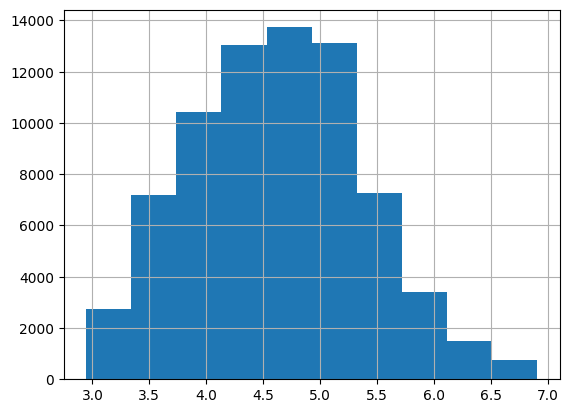

In [ ]:
data_lon.price = data_lon.price.apply(lambda x: x.replace("$", ""))
data_lon.price = data_lon.price.apply(lambda x: x.replace(",", ""))
data_lon.price = data_lon.price.astype("float")
print("99% properties have a price lower than {0: .2f}".format(np.percentile(data_lon.price, 99)))
print("99% properties have a price higher than {0: .2f}".format(np.percentile(data_lon.price, 1)))
data_lon = data_lon[(data_lon.price <= np.percentile(data_lon.price, 99.5)) & (data_lon.price > 0)]
data_lon = data_lon[(data_lon.price >= np.percentile(data_lon.price, 0.5)) & (data_lon.price > 0)]
print("After 99% properties have a price lower than {0: .2f}".format(np.percentile(data_lon.price, 99)))
print("After 99% properties have a price higher than {0: .2f}".format(np.percentile(data_lon.price, 1)))
data_lon.query('price > 5 & price < 1000').price.apply(np.log).hist()

In [ ]:
data_lon['is_wifi'] = data_lon['amenities'].apply(lambda x: 'wifi' in x.lower())*1
data_lon['is_alarm'] = data_lon['amenities'].apply(lambda x: 'smoke alarm' in x.lower())*1
data_lon['is_alarm2'] = data_lon['amenities'].apply(lambda x: 'carbon monoxide alarm' in x.lower())*1
data_lon['is_h_dryer'] = data_lon['amenities'].apply(lambda x: 'hair dryer' in x.lower())*1
data_lon['is_h_water'] = data_lon['amenities'].apply(lambda x: 'hot water' in x.lower())*1
data_lon['is_kitchen'] = data_lon['amenities'].apply(lambda x: 'kitchen' in x.lower())*1
data_lon['is_washer'] = data_lon['amenities'].apply(lambda x: 'washer' in x.lower())*1
data_lon['is_free_parking'] = data_lon['amenities'].apply(lambda x: 'free parking on premises' in x.lower())*1
data_lon['is_f_aid_kit'] = data_lon['amenities'].apply(lambda x: 'first aid kit' in x.lower())*1
data_lon['is_pets'] = data_lon['amenities'].apply(lambda x: 'pets allowed' in x.lower())*1
data_lon['is_smoking'] = data_lon['amenities'].apply(lambda x: 'smoking allowed' in x.lower())*1
data_lon['is_heating'] = data_lon['amenities'].apply(lambda x: 'Heating' in x.lower())*1
data_lon['is_tv'] = data_lon['amenities'].apply(lambda x: 'tv' in x.lower())*1
data_lon['is_essentials'] = data_lon['amenities'].apply(lambda x: 'essentials' in x.lower())*1

data_lon['bedrooms2'] = data_lon.bedrooms**2
data_lon['n_amenities'] = data_lon['amenities'].apply(lambda x: len(x.split(',')))

Regression

In [ ]:
data_lon.replace({'host_is_superhost' : {'t' : 1, 'f' : 0}}, inplace=True)
all_num_feats = [x for x in data_lon.dtypes[data_lon.dtypes != 'object'].index if not ('id' in x) and not ('url' in x) and not ('price' in x) ]
" + ".join(all_num_feats)

'host_is_superhost + host_listings_count + host_total_listings_count + neighbourhood_group_cleansed + latitude + longitude + accommodates + bathrooms + bedrooms + beds + minimum_nights + maximum_nights + minimum_minimum_nights + maximum_minimum_nights + minimum_maximum_nights + maximum_maximum_nights + minimum_nights_avg_ntm + maximum_nights_avg_ntm + calendar_updated + availability_30 + availability_60 + availability_90 + availability_365 + number_of_reviews + number_of_reviews_ltm + number_of_reviews_l30d + review_scores_rating + review_scores_accuracy + review_scores_cleanliness + review_scores_checkin + review_scores_communication + review_scores_location + review_scores_value + license + calculated_host_listings_count + calculated_host_listings_count_entire_homes + calculated_host_listings_count_private_rooms + calculated_host_listings_count_shared_rooms + reviews_per_month + is_wifi + is_alarm + is_alarm2 + is_h_dryer + is_h_water + is_kitchen + is_washer + is_free_parking + is_p

In [ ]:

model = smf.ols(
    '''price ~  host_is_superhost + bedrooms + beds +
            minimum_nights + number_of_reviews +
             + review_scores_rating + is_wifi + is_tv + n_amenities + is_smoking + is_essentials + is_pets + is_free_parking + is_alarm + is_kitchen
             ''',
    data=data_lon.fillna(0)).fit()


print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     989.5
Date:                Sat, 17 Jun 2023   Prob (F-statistic):               0.00
Time:                        12:28:50   Log-Likelihood:            -4.9438e+05
No. Observations:               74542   AIC:                         9.888e+05
Df Residuals:                   74526   BIC:                         9.889e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              198.9699 

In [ ]:
data_lon['bathrooms'] = data_lon['bathrooms'].fillna(1)

Krótkie podsumowanie,
liczba dodatów ma znaczenie, a ich jakoś nie.
np is_free_parking(bezplatny prywatny parking obok miezkania) lub heating.

(0.002102496223209049,
 113.20568046967308,
 -21.598787873776104,
 54.28459630623419)

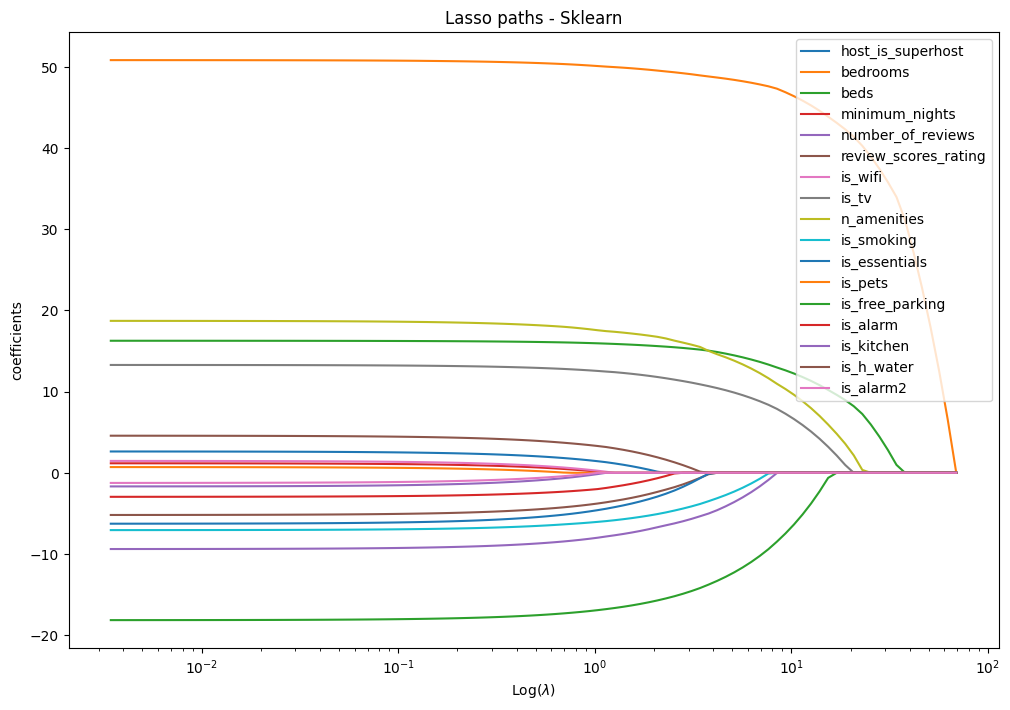

In [ ]:
variables = ['host_is_superhost', 'bedrooms', 'beds',
            'minimum_nights', 'number_of_reviews'
             , 'review_scores_rating'] + ['is_wifi', 'is_tv', 'n_amenities','is_smoking','is_essentials','is_pets','is_free_parking','is_alarm','is_kitchen','is_h_water','is_alarm2']

data_subset = data_lon.loc[:, variables + ['price']]
data_subset.dropna(inplace=True)

X = data_subset.loc[:,variables]
X = preprocessing.scale(X)
y = np.array(data_subset.price)

alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps = 5e-5)


plt.figure(figsize = (12,8))

for i in range(X.shape[1]):
    plt.plot(alphas_lasso, coefs_lasso[i], label = variables[i])

plt.xscale('log')
plt.xlabel('Log($\\lambda$)')
plt.ylabel('coefficients')
plt.title('Lasso paths - Sklearn')
plt.legend()
plt.axis('tight')

In [ ]:


variables = ['host_is_superhost', 'bedrooms', 'beds',
            'minimum_nights', 'number_of_reviews'
             , 'review_scores_rating'] + ['is_wifi', 'is_tv', 'n_amenities','is_smoking','is_essentials','is_pets','is_free_parking','is_alarm','is_kitchen','is_h_water','is_alarm2']

data_subset = data_lon.loc[:, variables + ['price']]
data_subset.dropna(inplace=True)
data_subset = data_subset.iloc[:1000,:]

X = data_subset.loc[:,variables]

y = np.array(data_subset.price)

model = xgboost.XGBRegressor(n_estimators=1000, verbosity=1)
model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
predicted = model.predict(X)
mean_squared_error(y, predicted)

1.7435492548151632

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
X.iloc[0,:]

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


host_is_superhost        0.00
bedrooms                 1.00
beds                     1.00
minimum_nights           5.00
number_of_reviews        4.00
review_scores_rating     3.67
is_wifi                  1.00
is_tv                    1.00
n_amenities             11.00
is_smoking               0.00
is_essentials            1.00
is_pets                  0.00
is_free_parking          0.00
is_alarm                 1.00
is_kitchen               1.00
is_h_water               0.00
is_alarm2                1.00
Name: 3, dtype: float64

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


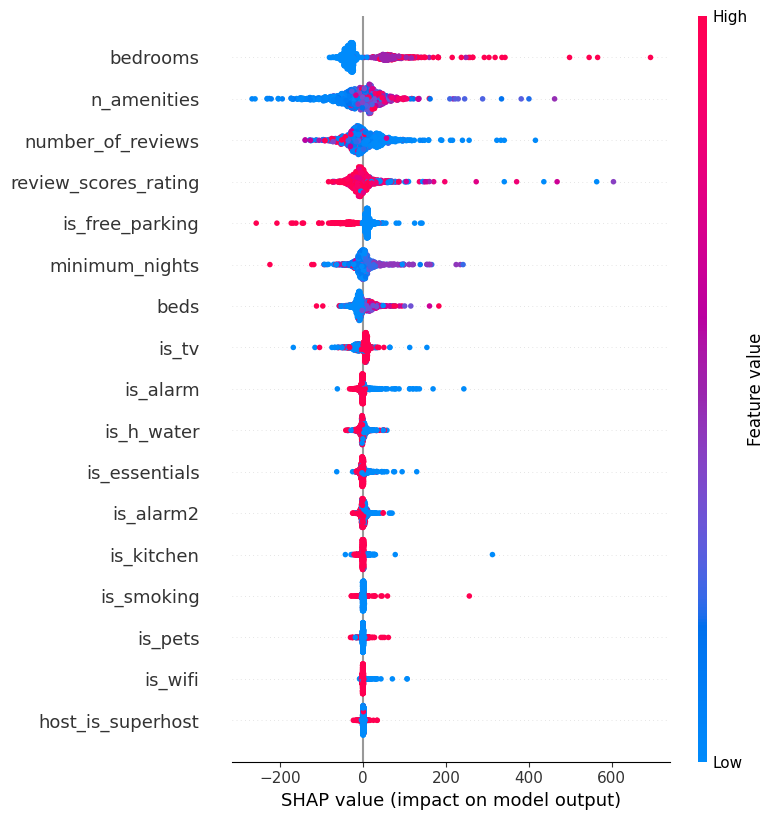

In [ ]:
shap.summary_plot(shap_values, features=X, feature_names=X.columns)

In [ ]:
!pip install nltk -qq
import nltk
from nltk.probability import FreqDist
nltk.download('punkt')
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
data_lon['amenities'] = data_lon['amenities'].astype(str).str.lower()
regexp = RegexpTokenizer('\w+')
data_lon['text_token']=data_lon['amenities'].apply(regexp.tokenize)
data_lon['text_string'] = data_lon['text_token'].apply(lambda x: ' '.join([item for item in x if len(item)>2]))
t1 = data_lon['text_string'].values.tolist()
fdist = FreqDist(t1)
fdist.most_common(20)

[('', 565),
 ('washer kitchen smoke alarm carbon monoxide alarm wifi', 120),
 ('washer wifi kitchen', 109),
 ('first aid kit long term stays allowed kitchen refrigerator elevator lock bedroom door dedicated workspace bed linens heating wifi dishes and silverware stove microwave essentials oven',
  90),
 ('long term stays allowed hangers shampoo smoke alarm kitchen refrigerator hot water carbon monoxide alarm lock bedroom door dedicated workspace bed linens heating wifi dishes and silverware stove microwave essentials hot water kettle oven',
  85),
 ('washer kitchen smoke alarm wifi', 79),
 ('washer kitchen smoke alarm carbon monoxide alarm dedicated workspace wifi',
  56),
 ('washer kitchen wifi heating essentials', 55),
 ('washer iron hangers hair dryer shampoo smoke alarm kitchen carbon monoxide alarm heating wifi essentials',
  48),
 ('washer iron hangers hair dryer shampoo smoke alarm kitchen carbon monoxide alarm heating wifi dryer essentials',
  48),
 ('washer first aid kit fire 

predicted model London

In [ ]:
#wifi
data_temp = pd.DataFrame({"is_wifi" : [x for x in range(0,2)]})
data_temp['review_scores_rating'] = 3.65
data_temp['host_is_superhost'] = 0
data_temp['bedrooms'] = 1
data_temp['beds'] = 1
data_temp['number_of_reviews'] = 4
data_temp['minimum_nights'] = 5
data_temp['is_tv'] = 1
data_temp['n_amenities'] = 11
data_temp['is_smoking'] = 0
data_temp['is_essentials'] = 1
data_temp['is_pets'] = 0
data_temp['is_free_parking'] = 0
data_temp['is_alarm'] = 1
data_temp['is_alarm2'] = 1
data_temp['is_kitchen'] = 1
data_temp['is_h_water'] = 0
data_temp = data_temp.reindex(columns=data_subset.columns)
data_temp.drop('price', axis=1, inplace=True)


predictions_temp = model.predict(data_temp)

plt.scatter(x=data_temp.is_wifi, y=predictions_temp)
plt.show()

array([ 89.669136, 100.000015], dtype=float32)

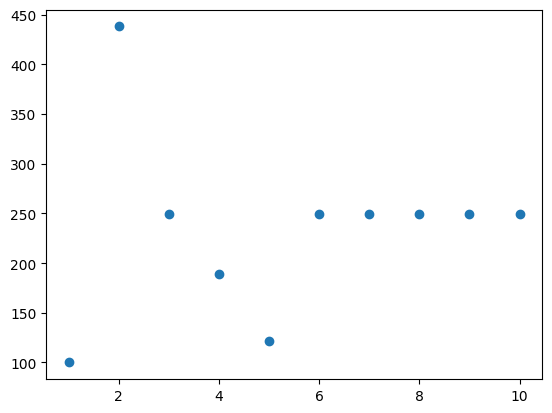

In [ ]:
#bedrooms
data_temp = pd.DataFrame({"bedrooms" : [x for x in range(1,11)]})
data_temp['host_is_superhost'] = 0
data_temp['beds'] = 1
data_temp['minimum_nights'] = 5
data_temp['number_of_reviews'] = 4
data_temp['review_scores_rating'] = 3.67
data_temp['is_wifi'] = 1
data_temp['is_tv'] = 1
data_temp['n_amenities'] = 11
data_temp['is_smoking'] = 0
data_temp['is_essentials'] = 1
data_temp['is_pets'] = 0
data_temp['is_free_parking'] = 0
data_temp['is_alarm'] = 1
data_temp['is_alarm2'] = 1
data_temp['is_kitchen'] = 1
data_temp['is_h_water'] = 0
data_temp = data_temp.reindex(columns=data_subset.columns)
data_temp.drop('price', axis=1, inplace=True)


predictions_temp = model.predict(data_temp)

predictions_temp


plt.scatter(x=data_temp.bedrooms, y=predictions_temp)
plt.show()


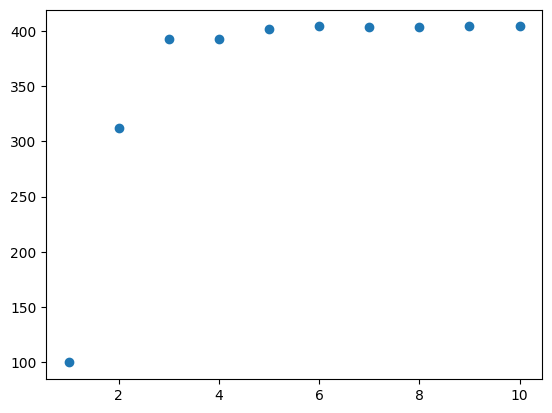

In [ ]:
#beds
data_temp = pd.DataFrame({"beds" : [x for x in range(1,11)]})
data_temp['host_is_superhost'] = 0
data_temp['bedrooms'] = 1
data_temp['minimum_nights'] = 5
data_temp['number_of_reviews'] = 4
data_temp['review_scores_rating'] = 3.67
data_temp['is_wifi'] = 1
data_temp['is_tv'] = 1
data_temp['n_amenities'] = 11
data_temp['is_smoking'] = 0
data_temp['is_essentials'] = 1
data_temp['is_pets'] = 0
data_temp['is_free_parking'] = 0
data_temp['is_alarm'] = 1
data_temp['is_alarm2'] = 1
data_temp['is_kitchen'] = 1
data_temp['is_h_water'] = 0
data_temp = data_temp.reindex(columns=data_subset.columns)
data_temp.drop('price', axis=1, inplace=True)


predictions_temp = model.predict(data_temp)

predictions_temp


plt.scatter(x=data_temp.beds, y=predictions_temp)
plt.show()

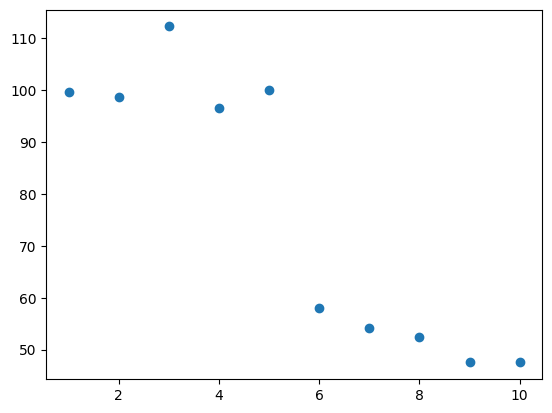

In [ ]:
#minimum_nights
data_temp = pd.DataFrame({"minimum_nights" : [x for x in range(1,11)]})
data_temp['host_is_superhost'] = 0
data_temp['bedrooms'] = 1
data_temp['beds'] = 1
data_temp['number_of_reviews'] = 4
data_temp['review_scores_rating'] = 3.67
data_temp['is_wifi'] = 1
data_temp['is_tv'] = 1
data_temp['n_amenities'] = 11
data_temp['is_smoking'] = 0
data_temp['is_essentials'] = 1
data_temp['is_pets'] = 0
data_temp['is_free_parking'] = 0
data_temp['is_alarm'] = 1
data_temp['is_alarm2'] = 1
data_temp['is_kitchen'] = 1
data_temp['is_h_water'] = 0
data_temp = data_temp.reindex(columns=data_subset.columns)
data_temp.drop('price', axis=1, inplace=True)


predictions_temp = model.predict(data_temp)

predictions_temp


plt.scatter(x=data_temp.minimum_nights, y=predictions_temp)
plt.show()

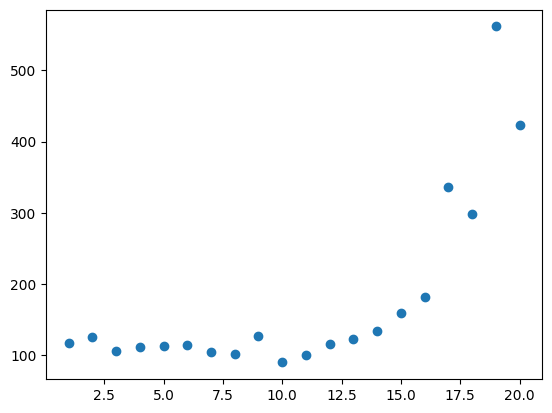

In [ ]:
#amenities
data_temp = pd.DataFrame({"n_amenities" : [x for x in range(1,21)]})
data_temp['host_is_superhost'] = 0
data_temp['bedrooms'] = 1
data_temp['beds'] = 1
data_temp['number_of_reviews'] = 4
data_temp['review_scores_rating'] = 3.67
data_temp['is_wifi'] = 1
data_temp['is_tv'] = 1
data_temp['minimum_nights'] = 5
data_temp['is_smoking'] = 0
data_temp['is_essentials'] = 1
data_temp['is_pets'] = 0
data_temp['is_free_parking'] = 0
data_temp['is_alarm'] = 1
data_temp['is_alarm2'] = 1
data_temp['is_kitchen'] = 1
data_temp['is_h_water'] = 0
data_temp = data_temp.reindex(columns=data_subset.columns)
data_temp.drop('price', axis=1, inplace=True)


predictions_temp = model.predict(data_temp)

predictions_temp


plt.scatter(x=data_temp.n_amenities, y=predictions_temp)
plt.show()

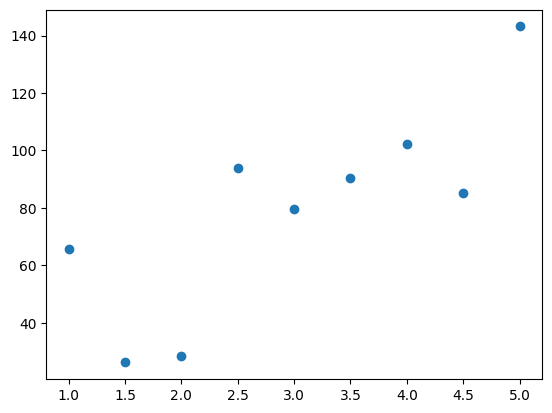

In [ ]:
#review_scores_rating
data_temp = pd.DataFrame({"review_scores_rating" : [x for x in np.arange(1, 5.1, 0.5)]})
data_temp['host_is_superhost'] = 0
data_temp['bedrooms'] = 1
data_temp['beds'] = 1
data_temp['number_of_reviews'] = 4
data_temp['minimum_nights'] = 5
data_temp['is_wifi'] = 1
data_temp['is_tv'] = 1
data_temp['n_amenities'] = 11
data_temp['is_smoking'] = 0
data_temp['is_essentials'] = 1
data_temp['is_pets'] = 0
data_temp['is_free_parking'] = 0
data_temp['is_alarm'] = 1
data_temp['is_alarm2'] = 1
data_temp['is_kitchen'] = 1
data_temp['is_h_water'] = 0
data_temp = data_temp.reindex(columns=data_subset.columns)
data_temp.drop('price', axis=1, inplace=True)


predictions_temp = model.predict(data_temp)

plt.scatter(x=data_temp.review_scores_rating, y=predictions_temp)
plt.show()

Most frequent sets of ameniies,

Next part is Dublin, same as london

99% properties have a price lower than  1570.00
99% properties have a price higher than  22.00
After 99% properties have a price lower than  1272.70
After 99% properties have a price higher than  25.00
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     112.7
Date:                Sat, 17 Jun 2023   Prob (F-statistic):          1.12e-317
Time:                        12:29:38   Log-Likelihood:                -52256.
No. Observations:                7816   AIC:                         1.045e+05
Df Residuals:                    7800   BIC:                         1.047e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
        

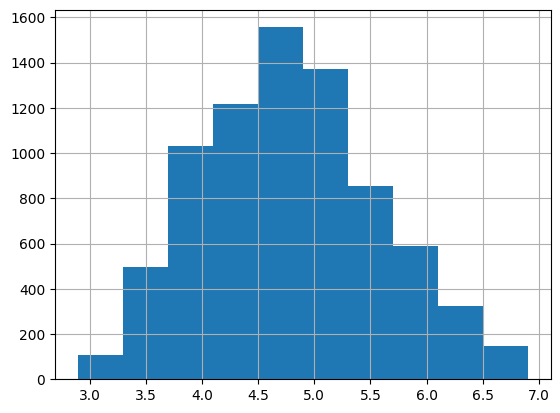

In [ ]:
data_dub.price = data_dub.price.apply(lambda x: x.replace("$", ""))
data_dub.price = data_dub.price.apply(lambda x: x.replace(",", ""))
data_dub.price = data_dub.price.astype("float")
print("99% properties have a price lower than {0: .2f}".format(np.percentile(data_dub.price, 99)))
print("99% properties have a price higher than {0: .2f}".format(np.percentile(data_dub.price, 1)))
data_dub = data_dub[(data_dub.price <= np.percentile(data_dub.price, 99.5)) & (data_dub.price > 0)]
data_dub = data_dub[(data_dub.price >= np.percentile(data_dub.price, 0.5)) & (data_dub.price > 0)]
print("After 99% properties have a price lower than {0: .2f}".format(np.percentile(data_dub.price, 99)))
print("After 99% properties have a price higher than {0: .2f}".format(np.percentile(data_dub.price, 1)))
data_dub.query('price > 5 & price < 1000').price.apply(np.log).hist()

data_dub['is_wifi'] = data_dub['amenities'].apply(lambda x: 'wifi' in x.lower())*1
data_dub['is_alarm'] = data_dub['amenities'].apply(lambda x: 'smoke alarm' in x.lower())*1
data_dub['is_alarm2'] = data_dub['amenities'].apply(lambda x: 'carbon monoxide alarm' in x.lower())*1
data_dub['is_h_dryer'] = data_dub['amenities'].apply(lambda x: 'hair dryer' in x.lower())*1
data_dub['is_h_water'] = data_dub['amenities'].apply(lambda x: 'hot water' in x.lower())*1
data_dub['is_kitchen'] = data_dub['amenities'].apply(lambda x: 'kitchen' in x.lower())*1
data_dub['is_washer'] = data_dub['amenities'].apply(lambda x: 'washer' in x.lower())*1
data_dub['is_free_parking'] = data_dub['amenities'].apply(lambda x: 'free parking on premises' in x.lower())*1
data_dub['is_f_aid_kit'] = data_dub['amenities'].apply(lambda x: 'first aid kit' in x.lower())*1
data_dub['is_pets'] = data_dub['amenities'].apply(lambda x: 'pets allowed' in x.lower())*1
data_dub['is_smoking'] = data_dub['amenities'].apply(lambda x: 'smoking allowed' in x.lower())*1
data_dub['is_heating'] = data_dub['amenities'].apply(lambda x: 'Heating' in x.lower())*1
data_dub['is_tv'] = data_dub['amenities'].apply(lambda x: 'tv' in x.lower())*1
data_dub['is_essentials'] = data_dub['amenities'].apply(lambda x: 'essentials' in x.lower())*1

data_dub['bedrooms2'] = data_dub.bedrooms**2
data_dub['n_amenities'] = data_dub['amenities'].apply(lambda x: len(x.split(',')))
data_dub.replace({'host_is_superhost' : {'t' : 1, 'f' : 0}}, inplace=True)
data_dub['bathrooms'] = data_dub['bathrooms'].fillna(1)


all_num_feats = [x for x in data_dub.dtypes[data_dub.dtypes != 'object'].index if not ('id' in x) and not ('url' in x) and not ('price' in x) ]
" + ".join(all_num_feats)

model = smf.ols(
    '''price ~  host_is_superhost + bedrooms + beds +
            minimum_nights + number_of_reviews +
             + review_scores_rating + is_wifi + is_tv + n_amenities + is_smoking + is_essentials + is_pets + is_free_parking + is_alarm + is_kitchen
             ''',
    data=data_dub.fillna(0)).fit()


print(model.summary())

(0.002464366370512443,
 132.6900228503768,
 -32.94209756056137,
 67.58684594083789)

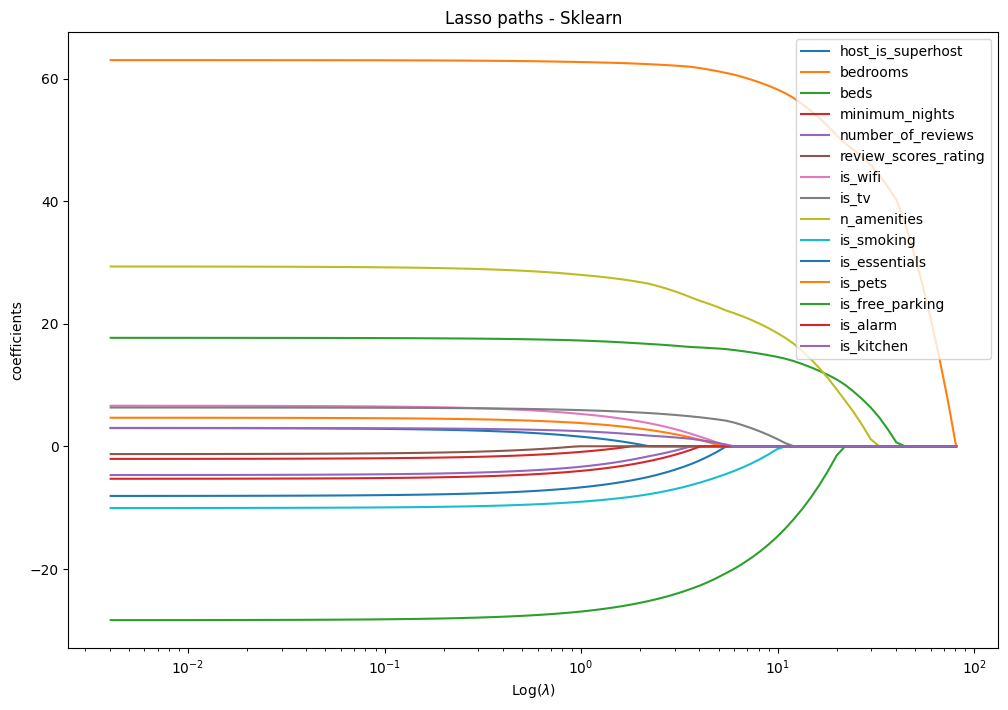

In [ ]:
variables = ['host_is_superhost', 'bedrooms', 'beds',
            'minimum_nights', 'number_of_reviews'
             , 'review_scores_rating'] + ['is_wifi', 'is_tv', 'n_amenities','is_smoking','is_essentials','is_pets','is_free_parking','is_alarm','is_kitchen']

data_subset = data_dub.loc[:, variables + ['price']]
data_subset.dropna(inplace=True)

X = data_subset.loc[:,variables]
X = preprocessing.scale(X)
y = np.array(data_subset.price)

alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps = 5e-5)

plt.figure(figsize = (12,8))

for i in range(X.shape[1]):
    plt.plot(alphas_lasso, coefs_lasso[i], label = variables[i])

plt.xscale('log')
plt.xlabel('Log($\\lambda$)')
plt.ylabel('coefficients')
plt.title('Lasso paths - Sklearn')
plt.legend()
plt.axis('tight')

In [ ]:
# XGBoost

variables = ['host_is_superhost', 'bedrooms', 'beds',
            'minimum_nights', 'number_of_reviews'
             , 'review_scores_rating'] + ['is_wifi', 'is_tv', 'n_amenities','is_smoking','is_essentials','is_pets','is_free_parking','is_alarm','is_kitchen','is_h_water','is_alarm2']

data_subset = data_dub.loc[:, variables + ['price']]
data_subset.dropna(inplace=True)
data_subset = data_subset.iloc[:1000,:]

X = data_subset.loc[:,variables]
y = np.array(data_subset.price)

model = xgboost.XGBRegressor(n_estimators=1000, verbosity=1)
model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
predicted = model.predict(X)
mean_squared_error(y, predicted)

3.9605153568859386

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
X.iloc[0,:]

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


host_is_superhost         1.00
bedrooms                  1.00
beds                      2.00
minimum_nights            3.00
number_of_reviews       276.00
review_scores_rating      4.79
is_wifi                   1.00
is_tv                     1.00
n_amenities              55.00
is_smoking                1.00
is_essentials             1.00
is_pets                   0.00
is_free_parking           0.00
is_alarm                  1.00
is_kitchen                0.00
is_h_water                1.00
is_alarm2                 1.00
Name: 0, dtype: float64

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


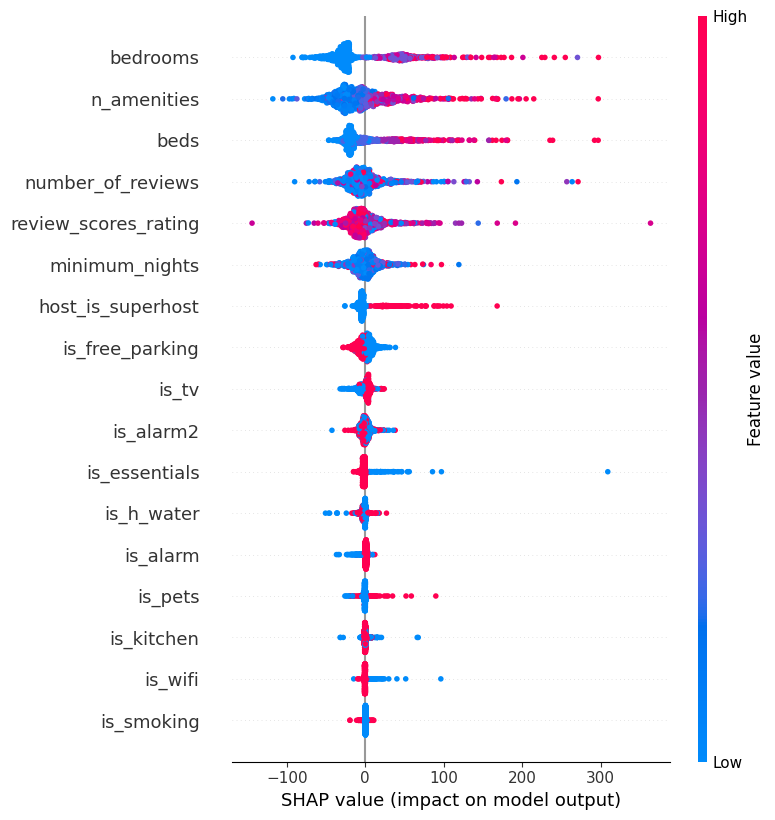

In [ ]:
shap.summary_plot(shap_values, features=X, feature_names=X.columns)

In [ ]:
data_dub['amenities'] = data_dub['amenities'].astype(str).str.lower()
regexp = RegexpTokenizer('\w+')
data_dub['text_token']=data_dub['amenities'].apply(regexp.tokenize)
data_dub['text_string'] = data_dub['text_token'].apply(lambda x: ' '.join([item for item in x if len(item)>2]))
t1 = data_dub['text_string'].values.tolist()
fdist = FreqDist(t1)
fdist.most_common(20)

[('kitchen security cameras property smoke alarm carbon monoxide alarm self check fire extinguisher keypad',
  40),
 ('kitchen wifi hot water kettle microwave heating smoke alarm essentials hangers bed linens refrigerator dishes and silverware lock bedroom door dedicated workspace stove oven hot water long term stays allowed shampoo',
  34),
 ('', 22),
 ('kitchen wifi smoke alarm self check keypad', 16),
 ('kitchen wifi washer', 15),
 ('kitchen washer smoke alarm carbon monoxide alarm fire extinguisher', 15),
 ('kitchen wifi security cameras property smoke alarm carbon monoxide alarm self check fire extinguisher keypad',
  13),
 ('kitchen wifi hot water kettle microwave heating iron essentials hangers bed linens smoke alarm refrigerator private entrance dishes and silverware lock bedroom door dedicated workspace oven cooking basics hot water long term stays allowed shampoo',
  12),
 ('kitchen wifi smoke alarm carbon monoxide alarm fire extinguisher', 12),
 ('kitchen wifi hot water kett

predicted  Dublin (data same as London)

In [ ]:
data_temp = pd.DataFrame({"bedrooms" : [x for x in range(1,11)]})
data_temp['host_is_superhost'] = 0
data_temp['beds'] = 1
data_temp['minimum_nights'] = 5
data_temp['number_of_reviews'] = 4
data_temp['review_scores_rating'] = 3.67
data_temp['is_wifi'] = 1
data_temp['is_tv'] = 1
data_temp['n_amenities'] = 11
data_temp['is_smoking'] = 0
data_temp['is_essentials'] = 1
data_temp['is_pets'] = 0
data_temp['is_free_parking'] = 0
data_temp['is_alarm'] = 1
data_temp['is_alarm2'] = 1
data_temp['is_kitchen'] = 1
data_temp['is_h_water'] = 0


data_temp.head()

,bedrooms,host_is_superhost,beds,minimum_nights,number_of_reviews,review_scores_rating,is_wifi,is_tv,n_amenities,is_smoking,is_essentials,is_pets,is_free_parking,is_alarm,is_alarm2,is_kitchen,is_h_water
0,1,0,1,5,4,3.67,1,1,11,0,1,0,0,1,1,1,0
1,2,0,1,5,4,3.67,1,1,11,0,1,0,0,1,1,1,0
2,3,0,1,5,4,3.67,1,1,11,0,1,0,0,1,1,1,0
3,4,0,1,5,4,3.67,1,1,11,0,1,0,0,1,1,1,0
4,5,0,1,5,4,3.67,1,1,11,0,1,0,0,1,1,1,0


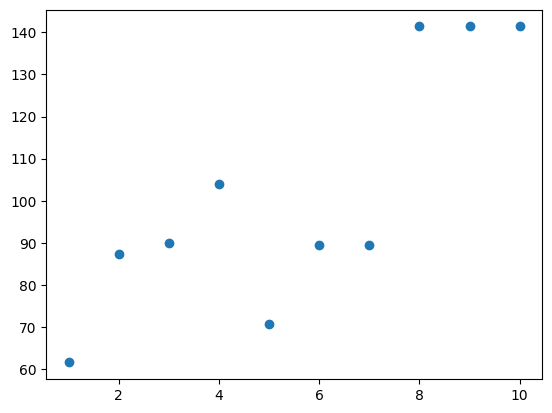

In [ ]:



data_temp = data_temp.reindex(columns=data_subset.columns)
data_temp.drop('price', axis=1, inplace=True)


predictions_temp = model.predict(data_temp)

predictions_temp


plt.scatter(x=data_temp.bedrooms, y=predictions_temp)
plt.show()

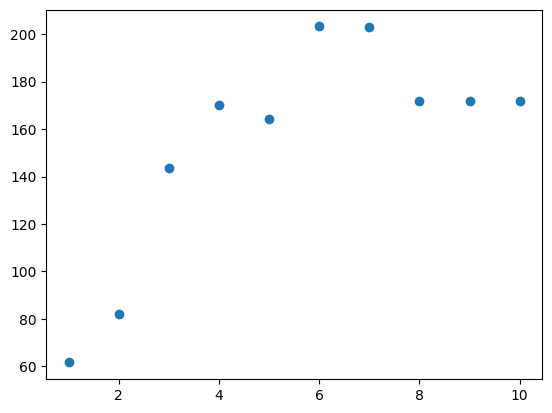

In [ ]:
#beds
data_temp = pd.DataFrame({"beds" : [x for x in range(1,11)]})
data_temp['host_is_superhost'] = 0
data_temp['bedrooms'] = 1
data_temp['minimum_nights'] = 5
data_temp['number_of_reviews'] = 4
data_temp['review_scores_rating'] = 3.67
data_temp['is_wifi'] = 1
data_temp['is_tv'] = 1
data_temp['n_amenities'] = 11
data_temp['is_smoking'] = 0
data_temp['is_essentials'] = 1
data_temp['is_pets'] = 0
data_temp['is_free_parking'] = 0
data_temp['is_alarm'] = 1
data_temp['is_alarm2'] = 1
data_temp['is_kitchen'] = 1
data_temp['is_h_water'] = 0
data_temp = data_temp.reindex(columns=data_subset.columns)
data_temp.drop('price', axis=1, inplace=True)


predictions_temp = model.predict(data_temp)

predictions_temp


plt.scatter(x=data_temp.beds, y=predictions_temp)
plt.show()

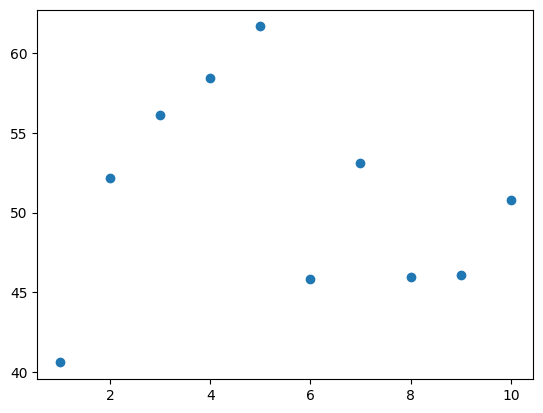

In [ ]:
#minimum_nights
data_temp = pd.DataFrame({"minimum_nights" : [x for x in range(1,11)]})
data_temp['host_is_superhost'] = 0
data_temp['bedrooms'] = 1
data_temp['beds'] = 1
data_temp['number_of_reviews'] = 4
data_temp['review_scores_rating'] = 3.67
data_temp['is_wifi'] = 1
data_temp['is_tv'] = 1
data_temp['n_amenities'] = 11
data_temp['is_smoking'] = 0
data_temp['is_essentials'] = 1
data_temp['is_pets'] = 0
data_temp['is_free_parking'] = 0
data_temp['is_alarm'] = 1
data_temp['is_alarm2'] = 1
data_temp['is_kitchen'] = 1
data_temp['is_h_water'] = 0
data_temp = data_temp.reindex(columns=data_subset.columns)
data_temp.drop('price', axis=1, inplace=True)


predictions_temp = model.predict(data_temp)

predictions_temp


plt.scatter(x=data_temp.minimum_nights, y=predictions_temp)
plt.show()

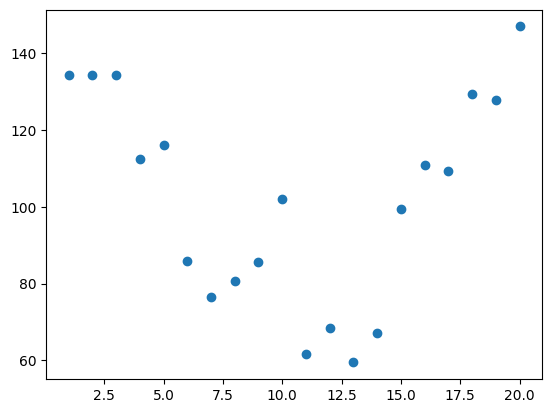

In [ ]:
#amenities
data_temp = pd.DataFrame({"n_amenities" : [x for x in range(1,21)]})
data_temp['host_is_superhost'] = 0
data_temp['bedrooms'] = 1
data_temp['beds'] = 1
data_temp['number_of_reviews'] = 4
data_temp['review_scores_rating'] = 3.67
data_temp['is_wifi'] = 1
data_temp['is_tv'] = 1
data_temp['minimum_nights'] = 5
data_temp['is_smoking'] = 0
data_temp['is_essentials'] = 1
data_temp['is_pets'] = 0
data_temp['is_free_parking'] = 0
data_temp['is_alarm'] = 1
data_temp['is_alarm2'] = 1
data_temp['is_kitchen'] = 1
data_temp['is_h_water'] = 0
data_temp = data_temp.reindex(columns=data_subset.columns)
data_temp.drop('price', axis=1, inplace=True)


predictions_temp = model.predict(data_temp)

predictions_temp


plt.scatter(x=data_temp.n_amenities, y=predictions_temp)
plt.show()

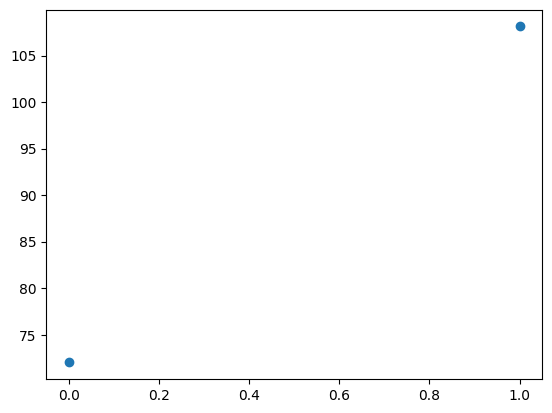

In [ ]:
#review_scores_rating
data_temp = pd.DataFrame({"review_scores_rating" : [x for x in np.arange(1, 5.1, 0.5)]})
data_temp['review_scores_rating']
data_temp['host_is_superhost'] = 0
data_temp['bedrooms'] = 1
data_temp['beds'] = 1
data_temp['number_of_reviews'] = 4
data_temp['minimum_nights'] = 5
data_temp['is_wifi'] = 0
data_temp['is_tv'] = 1
data_temp['n_amenities'] = 11
data_temp['is_smoking'] = 0
data_temp['is_essentials'] = 1
data_temp['is_pets'] = 0
data_temp['is_free_parking'] = 0
data_temp['is_alarm'] = 1
data_temp['is_alarm2'] = 1
data_temp['is_kitchen'] = 1
data_temp['is_h_water'] = 0
data_temp = data_temp.reindex(columns=data_subset.columns)
data_temp.drop('price', axis=1, inplace=True)


predictions_temp = model.predict(data_temp)

plt.scatter(x=data_temp.review_scores_rating, y=predictions_temp)
plt.show()

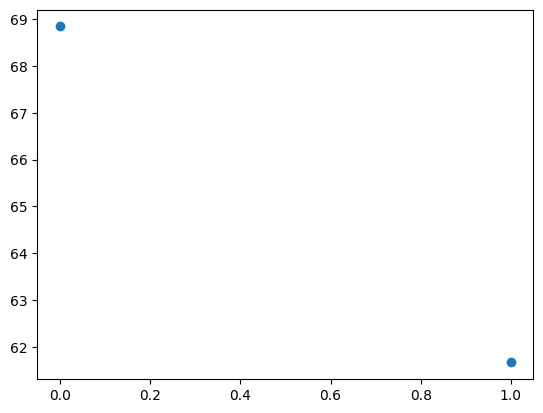

In [ ]:
#review_scores_rating
data_temp = pd.DataFrame({"is_wifi" : [x for x in range(0,2)]})
data_temp['review_scores_rating'] = 3.65
data_temp['host_is_superhost'] = 0
data_temp['bedrooms'] = 1
data_temp['beds'] = 1
data_temp['number_of_reviews'] = 4
data_temp['minimum_nights'] = 5
data_temp['is_tv'] = 1
data_temp['n_amenities'] = 11
data_temp['is_smoking'] = 0
data_temp['is_essentials'] = 1
data_temp['is_pets'] = 0
data_temp['is_free_parking'] = 0
data_temp['is_alarm'] = 1
data_temp['is_alarm2'] = 1
data_temp['is_kitchen'] = 1
data_temp['is_h_water'] = 0
data_temp = data_temp.reindex(columns=data_subset.columns)
data_temp.drop('price', axis=1, inplace=True)


predictions_temp = model.predict(data_temp)

plt.scatter(x=data_temp.is_wifi, y=predictions_temp)
plt.show()

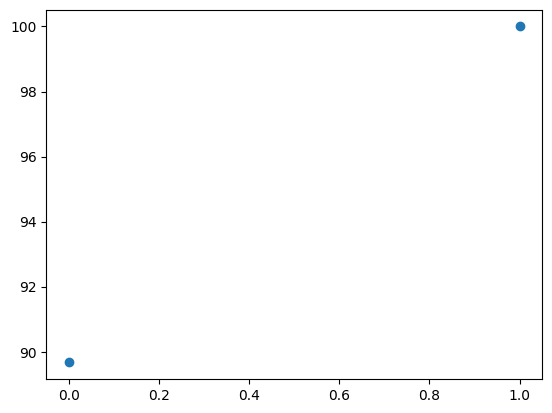

In [ ]:
#wifi
data_temp = pd.DataFrame({"is_wifi" : [x for x in range(0,2)]})
data_temp['review_scores_rating'] = 3.65
data_temp['host_is_superhost'] = 0
data_temp['bedrooms'] = 1
data_temp['beds'] = 1
data_temp['number_of_reviews'] = 4
data_temp['minimum_nights'] = 5
data_temp['is_tv'] = 1
data_temp['n_amenities'] = 11
data_temp['is_smoking'] = 0
data_temp['is_essentials'] = 1
data_temp['is_pets'] = 0
data_temp['is_free_parking'] = 0
data_temp['is_alarm'] = 1
data_temp['is_alarm2'] = 1
data_temp['is_kitchen'] = 1
data_temp['is_h_water'] = 0
data_temp = data_temp.reindex(columns=data_subset.columns)
data_temp.drop('price', axis=1, inplace=True)


predictions_temp = model.predict(data_temp)

plt.scatter(x=data_temp.is_wifi, y=predictions_temp)
plt.show()